## Explore Data

In [1]:
import numpy as np
import librosa
from librosa import display

In [2]:
y, sr = librosa.load("genres/classical/classical.00000.wav")
hop_length = 512
mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=hop_length, n_mfcc=13)

In [3]:
print(mfcc.shape)
print(mfcc.flatten().shape)

(13, 1293)
(16809,)


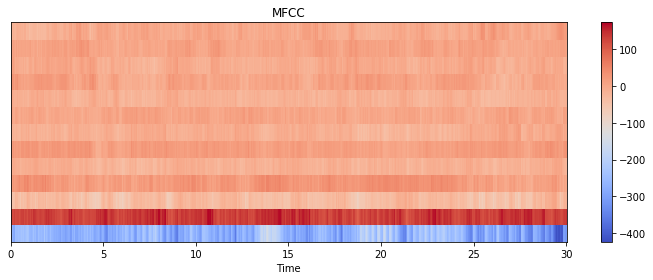

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

## Load Data

In [6]:
all_genres = ['blues','classical','country','disco','hiphop','jazz','metal','pop','reggae','rock']
num_songs = 100
Y_LIMIT = 660000

In [7]:
# Loads n_songs songs from each genre in load_genres.  
def load_dataset(genres=all_genres, n_songs=num_songs):
    X, Y = None, None
    for g_idx, g in enumerate(genres):
        for s_idx in range(n_songs):
            y, sr = librosa.load(f'genres/{g}/{g}.000{s_idx:02d}.wav')
            # Limit length of sample so that all features have the same length.
            y = y[:Y_LIMIT]
            mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=512, n_mfcc=13).flatten()
            
            if X is None:
                X = mfcc.reshape(1, mfcc.shape[0])
                Y = np.array([[g_idx]])
                
            else:
                X = np.vstack([X, mfcc])
                Y = np.vstack([Y, np.array([[g_idx]])])
    return X, Y

In [8]:
X, Y = load_dataset(all_genres, 100)
Y = Y.ravel()

In [9]:
print(X.shape, Y.shape)

(1000, 16770) (1000,)


## Models

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split,\
    cross_val_score, GridSearchCV
from sklearn.utils.multiclass import unique_labels
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import axes3d

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X[0]

array([-0.5440791 , -0.5192269 , -0.32152832, ...,  0.5927453 ,
        0.80659366,  0.6059533 ], dtype=float32)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, Y) 
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(750, 16770) (250, 16770) (750,) (250,)


In [59]:
def plot_confusion_matrix(test_labels, predictions, title):
    ax= plt.subplot()
    cm = confusion_matrix(test_labels, predictions)
    sns.heatmap(cm, annot=True, ax = ax, cmap = sns.cm.rocket_r); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title(f'{title}'); 
    ax.set_ylim(top=0, bottom=10)
    ax.xaxis.set_ticklabels(all_genres); ax.yaxis.set_ticklabels(all_genres);
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
    plt.show()

In [55]:
def plot_labels_3d(data, labels, title):
    pca = PCA(n_components=3)
    pca.fit(X_test)
    projected = pca.transform(X_test)
    fig = plt.figure(figsize=(15,10))
    fig.suptitle(title, fontsize=20) 
    ax = fig.add_subplot(111, projection='3d')
    for l, c in zip(range(0, 10),
                    ('blue', 'red', 'green', 'orange', 'yellow', 'black', 'purple', 'cyan', 'brown', 'pink')):
        ax.scatter(projected[y_test == l, 0],
                    projected[y_test == l, 1],
                    projected[y_test == l, 2],
                    color=c,
                    label='%s' % all_genres[l],
                    alpha=.5,
                    marker='o',
                    s=60
                    )
    ax.set_xlabel('PCA dimension 1')
    ax.set_ylabel('PCA dimension 2')
    ax.set_zlabel('PCA dimension 3')
    plt.grid()
    plt.legend(loc='upper right')
    plt.show()
    

## True labels plot

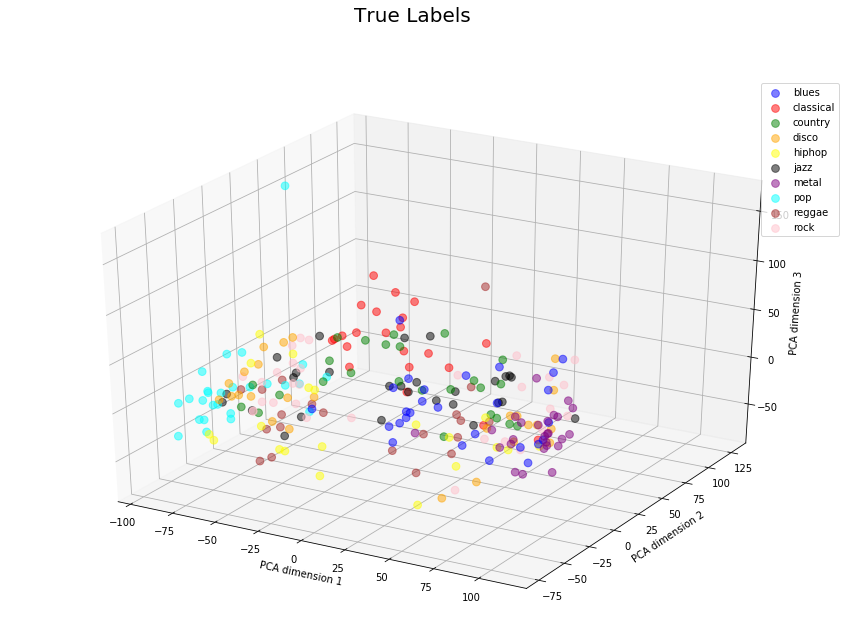

In [75]:
plot_labels_3d(X_test, y_test, 'True Labels')

## SVM Baseline

In [76]:
from sklearn.svm import SVC

In [77]:
params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [.01, .1, 1]},
                    {'kernel': ['linear'], 'C': [.01, .1, 1]}]

In [ ]:
svm_model = GridSearchCV(SVC(), params_grid, iid = False, cv=3)
svm_model.fit(X_train, y_train)

In [ ]:
# View the accuracy score
print('Best score for training data:', svm_model.best_score_,"\n") 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C,"\n") 
print('Best Kernel:',svm_model.best_estimator_.kernel,"\n")
print('Best gamma:',svm_model.best_estimator_.gamma,"\n")

final_model = svm_model.best_estimator_

In [ ]:
svm_predictions = final_model.predict(X_test)

In [ ]:
print(classification_report(y_test,svm_predictions))

In [ ]:
plot_confusion_matrix(y_test, svm_predictions, f'SVM, kernel={svm_model.best_estimator_.kernel}, C={svm_model.best_estimator_.C}')

In [ ]:
plot_labels_3d(X_test, svm_predictions, 'SVM Predicted Labels')

### LR

In [101]:
from sklearn.linear_model import LogisticRegression

In [102]:
params_grid = [{'C': [.01, .1, 1]}]

In [103]:
lr = GridSearchCV(LogisticRegression(solver='saga', multi_class='multinomial', max_iter=10),
                        params_grid, iid = False, cv=3)
lr.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
print('Best score for training data:', lr.best_score_,"\n") 

print('Best C:',lr.best_estimator_.C,"\n") 

lr_model = lr.best_estimator_

In [44]:
lr_predictions = lr_model.predict(X_test)

In [45]:
print(classification_report(y_test,lr_predictions))

              precision    recall  f1-score   support

           0       0.11      0.12      0.11        16
           1       0.77      0.85      0.81        27
           2       0.45      0.35      0.39        26
           3       0.53      0.36      0.43        28
           4       0.52      0.41      0.46        27
           5       0.48      0.54      0.51        28
           6       0.64      0.92      0.75        25
           7       0.61      0.92      0.73        24
           8       0.57      0.27      0.36        30
           9       0.21      0.26      0.23        19

    accuracy                           0.51       250
   macro avg       0.49      0.50      0.48       250
weighted avg       0.51      0.51      0.50       250



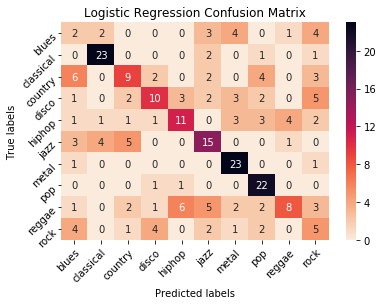

In [46]:
plot_confusion_matrix(y_test, lr_predictions, f'Logistic Regression, C={lr.best_estimator_.C}')

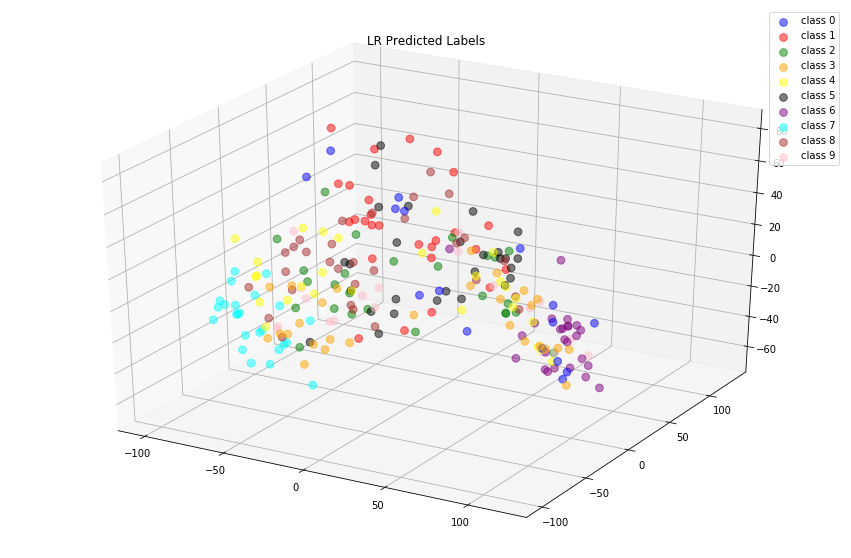

In [62]:
plot_labels_3d(X_test, lr_predictions, 'LR Predicted Labels')

### Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

In [38]:
params_grid = [{'n_estimators': [10, 20, 40, 80], 'max_features': ['sqrt', 'log2']}]

In [62]:
rf = GridSearchCV(RandomForestClassifier(),
                        params_grid, iid = False, cv=3)
rf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [63]:
print('Best score for training data:', rf.best_score_,"\n") 

print('Best n_estimators:',rf.best_estimator_.n_estimators,"\n")

print('Best max_features:',rf.best_estimator_.max_features,"\n") 

rf_model = rf.best_estimator_

Best score for training data: 0.45993969002254004 

Best n_estimators: 80 

Best max_features: sqrt 



In [64]:
rf_accuracy = rf_model.score(X_test, y_test)
rf_accuracy

0.464

In [65]:
rf_predictions = rf_model.predict(X_test)

In [66]:
print(classification_report(y_test,rf_predictions))

              precision    recall  f1-score   support

           0       0.50      0.33      0.40        27
           1       0.78      0.82      0.80        22
           2       0.18      0.16      0.17        25
           3       0.53      0.35      0.42        26
           4       0.43      0.30      0.35        20
           5       0.34      0.50      0.41        28
           6       0.70      0.88      0.78        26
           7       0.47      0.81      0.59        26
           8       0.38      0.30      0.33        20
           9       0.29      0.20      0.24        30

    accuracy                           0.46       250
   macro avg       0.46      0.46      0.45       250
weighted avg       0.45      0.46      0.45       250



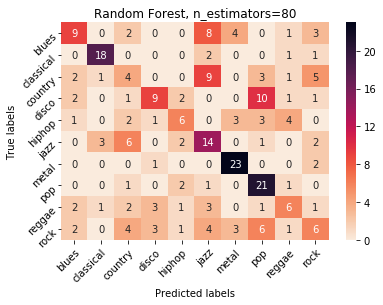

In [73]:
plot_confusion_matrix(y_test, rf_predictions, f'Random Forest, n_estimators={rf.best_estimator_.n_estimators}')

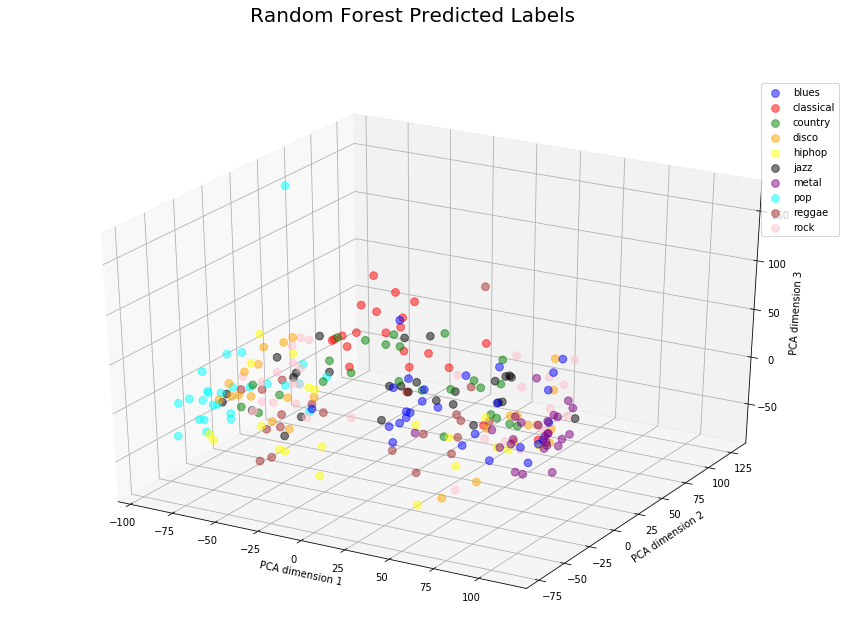

In [74]:
plot_labels_3d(X_test, rf_predictions, 'Random Forest Predicted Labels')